>### Forecasting Total Profit using a Prophet Forecasting Model

- In the last section  we will forecast total profit 3 years future

---
#### Cleaning & Preparing Data

In [21]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
df = pd.read_excel("Data.xls")
online = df.loc[df['SALES_CHANNEL'] == 'Online']
offline = df.loc[df['SALES_CHANNEL'] == 'Offline']

In [22]:
online.shape, offline.shape

((979, 13), (1026, 13))

In [23]:
cols = ['REGION','SALES_CHANNEL','UNITS_SOLD','COUNTRY','ITEM_TYPE','QUALITY_PRODUCT','ORDER_DATE','ORDER_ID','UNIT_PRICE','UNIT_COST','TOTAL_COST']
online.drop(cols, axis=1, inplace=True)
offline.drop(cols, axis=1, inplace=True)

online = online.sort_values('SHIP_DATE')
offline = offline.sort_values('SHIP_DATE')

online = online.groupby('SHIP_DATE')['TOTAL_PROFIT'].sum().reset_index()
offline = offline.groupby('SHIP_DATE')['TOTAL_PROFIT'].sum().reset_index()

---
#### Data exploration

In [24]:
online = online.set_index('SHIP_DATE')
offline = offline.set_index('SHIP_DATE')

y_online = online['TOTAL_PROFIT'].resample('MS').mean()
y_offline = offline['TOTAL_PROFIT'].resample('MS').mean()

online = pd.DataFrame({'SHIP_DATE':y_online.index, 'TOTAL_PROFIT':y_online.values})
offline = pd.DataFrame({'SHIP_DATE': y_offline.index, 'TOTAL_PROFIT': y_offline.values})

store = online.merge(offline, how='inner', on='SHIP_DATE')
store.rename(columns={'TOTAL_PROFIT_x': 'online_TP', 'TOTAL_PROFIT_y': 'offline_TP'}, inplace=True)
store.head()

,SHIP_DATE,online_TP,offline_TP
0,2010-01-01,151361.340000,589951.338333
1,2010-02-01,732704.212500,568745.743333
2,2010-03-01,541667.808462,496859.488000
3,2010-04-01,440911.431000,610470.077500
4,2010-05-01,508304.620000,485720.598571


#### Plotting graph of historical data

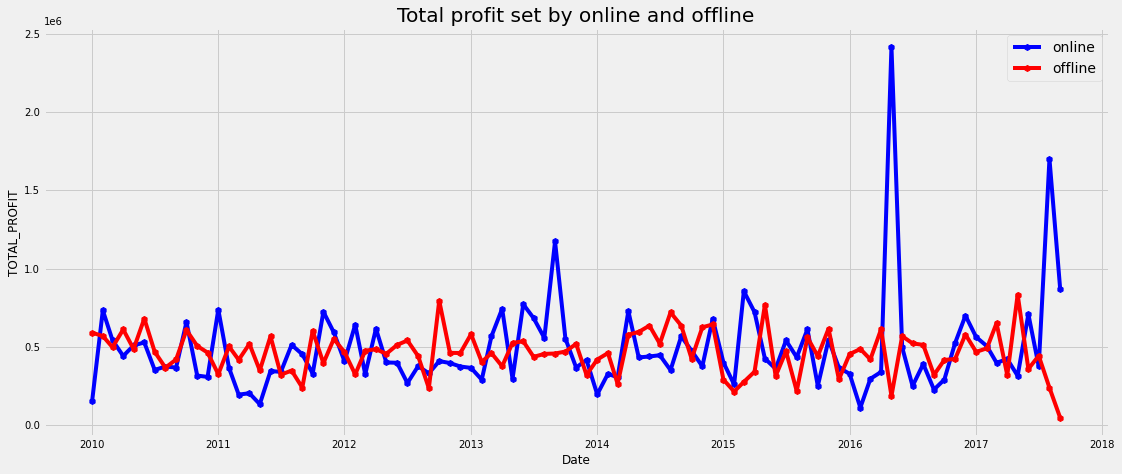

In [25]:
plt.figure(figsize=(17, 7))
plt.plot(store['SHIP_DATE'], store['online_TP'], 'b-',marker='h', label = 'online')
plt.plot(store['SHIP_DATE'], store['offline_TP'], 'r-',marker='h', label = 'offline')
plt.xlabel('Date'); plt.ylabel('TOTAL_PROFIT'); plt.title('Total profit set by online and offline')
plt.legend();

---
#### Prophet Forecasting Model
Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

#### Equation of the model is -

<p align="center">
  <img src="https://miro.medium.com/max/659/1*Oe2mGHiiwDMmRcBlbvS39Q.png?raw=true" alt="Sublime's custom image"/>
</p>

**where:**
- *g(t)* : trend models non-periodic changes (i.e. growth over time)
- *s(t)* : seasonality presents periodic changes (i.e. weekly, monthly, yearly)
- *h(t)* : ties in effects of holidays (on potentially irregular schedules ≥ 1 day(s))
- *e(t)* : covers idiosyncratic changes not accommodated by the model

**In other words, the procedure’s equation can be written**

<p align="center">
  <img src="https://miro.medium.com/max/399/1*ou96ceGd-wtOMFXSUl0Dtw.png?raw=true" alt="Sublime's custom image"/>
</p>

In [26]:
from fbprophet import Prophet
import logging

# disable informational messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

In [33]:
online = online.rename(columns={'SHIP_DATE': 'ds', 'TOTAL_PROFIT': 'y'})
online_model = Prophet(interval_width=0.95, daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True, seasonality_mode='multiplicative')
online_model.fit(online)

offline = offline.rename(columns={'SHIP_DATE': 'ds', 'TOTAL_PROFIT': 'y'})
offline_model = Prophet(interval_width=0.95, daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True, seasonality_mode='multiplicative')
offline_model.fit(offline)

In [43]:
online_forecast = online_model.make_future_dataframe(periods=12*5, freq='MS',include_history=True)
online_forecast = online_model.predict(online_forecast)

offline_forecast = offline_model.make_future_dataframe(periods=12*5, freq='MS',include_history=True)
offline_forecast = offline_model.predict(offline_forecast)

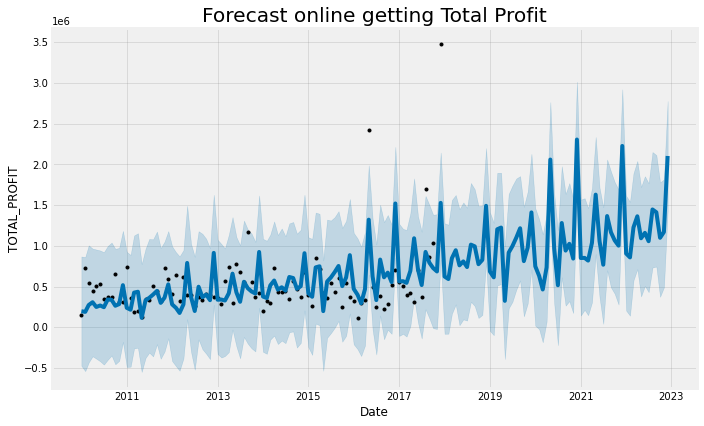

In [149]:
online_model.plot(online_forecast, xlabel = 'Date', ylabel = 'TOTAL_PROFIT')
plt.title('Forecast online getting Total Profit');

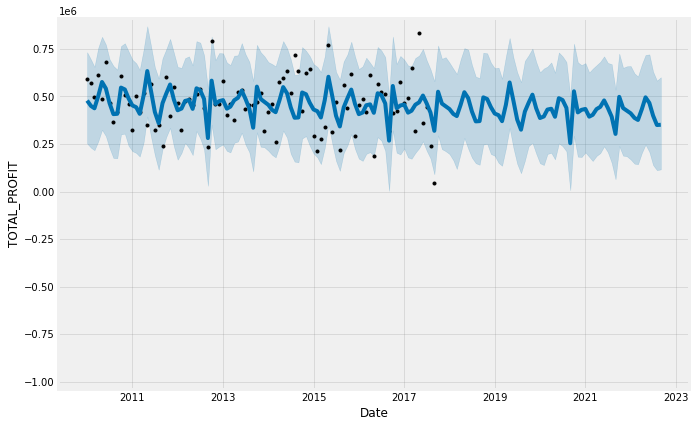

In [158]:
predict_fig = offline_model.plot(offline_forecast, xlabel = 'Date', ylabel = 'TOTAL_PROFIT')

# adjust figure to display dates from last year + the 90 day forecast
ylim = predict_fig.axes[0].get_ylim()
new_ylim = ( ylim[0]-(1000000))
predict_fig.axes[0].set_ylim(new_ylim);

---
#### Compare Forecasts

In [159]:
online_names = ['online_%s' % column for column in online_forecast.columns]
offline_names = ['offline_%s' % column for column in offline_forecast.columns]

merge_online_forecast = online_forecast.copy()
merge_offline_forecast = offline_forecast.copy()

merge_online_forecast.columns = online_names
merge_offline_forecast.columns = offline_names

forecast = pd.merge(merge_online_forecast, merge_offline_forecast, how = 'inner', left_on = 'online_ds', right_on = 'offline_ds')

forecast = forecast.rename(columns={'online_ds': 'Date'}).drop('offline_ds', axis=1)
forecast.head()

,Date,online_trend,online_yhat_lower,online_yhat_upper,online_trend_lower,online_trend_upper,online_multiplicative_terms,online_multiplicative_terms_lower,online_multiplicative_terms_upper,online_yearly,...,offline_multiplicative_terms,offline_multiplicative_terms_lower,offline_multiplicative_terms_upper,offline_yearly,offline_yearly_lower,offline_yearly_upper,offline_additive_terms,offline_additive_terms_lower,offline_additive_terms_upper,offline_yhat
0,2010-01-01,259464.032770,-472022.205813,8.698038e+05,259464.032770,259464.032770,-0.237683,-0.237683,-0.237683,-0.237683,...,-0.040757,-0.040757,-0.040757,-0.040757,-0.040757,-0.040757,0.0,0.0,0.0,478340.876161
1,2010-02-01,264472.978044,-537641.823062,8.627962e+05,264472.978044,264472.978044,-0.282517,-0.282517,-0.282517,-0.282517,...,-0.096335,-0.096335,-0.096335,-0.096335,-0.096335,-0.096335,0.0,0.0,0.0,450181.186131
2,2010-03-01,268997.186678,-430703.745474,1.006427e+06,268997.186678,268997.186678,0.018915,0.018915,0.018915,0.018915,...,-0.120512,-0.120512,-0.120512,-0.120512,-0.120512,-0.120512,0.0,0.0,0.0,437745.541422
3,2010-04-01,274006.131952,-355417.583731,9.666920e+05,274006.131952,274006.131952,0.125303,0.125303,0.125303,0.125303,...,0.011815,0.011815,0.011815,0.011815,0.011815,0.011815,0.0,0.0,0.0,503110.233909
4,2010-05-01,278853.498271,-384409.240531,9.553145e+05,278853.498271,278853.498271,-0.103157,-0.103157,-0.103157,-0.103157,...,0.159879,0.159879,0.159879,0.159879,0.159879,0.159879,0.0,0.0,0.0,576179.978301


---
#### Visualizing the Totil Profit forecast

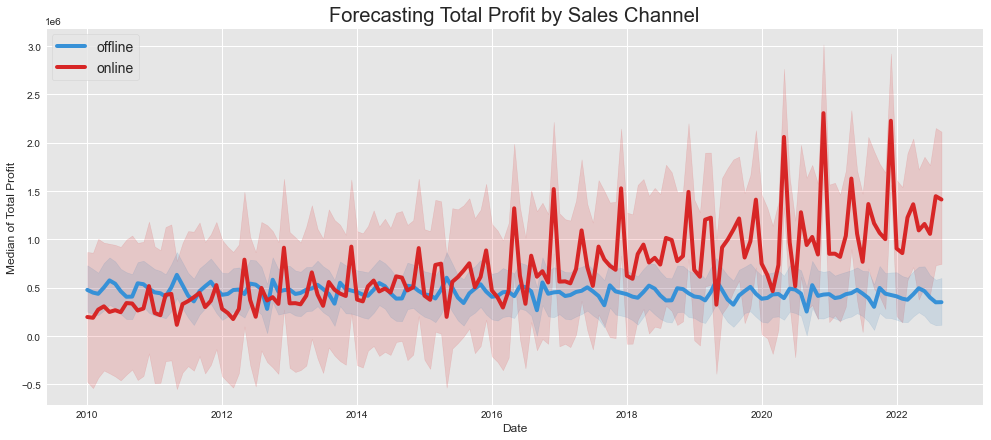

In [282]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='Set1')
sns_c = sns.color_palette(palette='Set1')

fig, ax = plt.subplots(figsize=(15, 6.5))
sns.lineplot(x='Date', y='offline_yhat', color='#3791D7', data=forecast, label='offline', ax=ax)

ax.fill_between(
    x=forecast['Date'],
    y1=forecast['online_yhat_lower'],
    y2=forecast['online_yhat_upper'],
    color=sns_c[0], 
    alpha=0.15
)
#D72626","#3791D7
sns.lineplot(x='Date', y='online_yhat', color='#D72626', data=forecast, label='online', ax=ax)
ax.fill_between(
    x=forecast['Date'],
    y1=forecast['offline_yhat_lower'],
    y2=forecast['offline_yhat_upper'],
    color=sns_c[1], 
    alpha=0.15
)
ax.legend(loc='upper left')
ax.set(title='Forecasting Total Profit by Sales Channel', ylabel='Median of Total Profit',xlabel='Date');

In [281]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=forecast.Date,
    y=forecast.offline_yhat,
    line=dict(width=0.5, color='#1f77b4'),
    stackgroup='one',
    hoverinfo='x+y',
    mode='lines',
    name='Offline'
))
fig.add_trace(go.Scatter(
    x=forecast.Date,
    y=forecast.online_yhat,
    line=dict(width=0.5, color='red'),
    stackgroup='one',
    hoverinfo='x+y',
    mode='lines',
    name='Online'
))
fig.update_layout(
    legend_title_text='Sales Channel',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
),
    yaxis_title="Median of Total Profit",
    xaxis_title="Date",
    title={
        'font_size':20,
        'text': "Forecasting Total Profit by Sales Channel",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

---
- Finally, we are get the last expecting result forecasting a total profit. The forecasting total profit indicators by **online** sales channel completely will grow in the last 5 years and **offline** will reduce